## PREPROCESSING DATA

[Source](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data)

[sentiment-analysis-on-movie-reviews]

In [5]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

In [6]:
api.authenticate()

In [9]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip', path='.data/')
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip',path='.data/')

In [44]:
import zipfile

In [15]:
with zipfile.ZipFile('data/test.tsv.zip','r') as f:
    f.extractall('data/')
    
with zipfile.ZipFile('data/train.tsv.zip','r') as f:
    f.extractall('data/')

#### Reading the data

In [73]:
import pandas as pd
df = pd.read_csv('data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The same sentence is copied multiple times, and all copies or duplicates has the same sentence id

In [74]:
print(f"The length of the dataframe is {len(df)}")
print(f"And the number of unique sentences are {len(df['SentenceId'].unique())}")

The length of the dataframe is 156060
And the number of unique sentences are 8529


<AxesSubplot:>

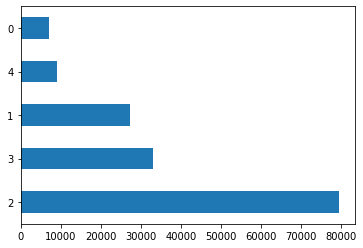

In [75]:
df['Sentiment'].value_counts().plot(kind='barh')

The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [76]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [77]:
from transformers import BertTokenizer

In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [79]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,truncation = True, padding='max_length', add_special_tokens=True, return_tensors='np') # the special tokens are specific to BERT

In [80]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [81]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [82]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [83]:
#saving it as a numpy binary file
import numpy as np
with open('data/movie-xids.npy','wb') as f:
    np.save(f, tokens['input_ids'])
with open('data/movie-xmask.npy','wb') as f:
    np.save(f, tokens['attention_mask'])

In [84]:
arr = df['Sentiment'].values

In [85]:
arr.shape

(156060,)

In [86]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [87]:
arr.max() + 1

5

In [88]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [89]:
labels[np.arange(num_samples), arr] = 1

In [90]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [91]:
with open('data/movies_labels.npy', 'wb') as f:
    np.save(f, labels)

## INPUT PIPELINE

In [92]:
import numpy as np

In [93]:
with open('data/movie-xids.npy','rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('data/movie-xmask.npy','rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('data/movies_labels.npy','rb') as f:
    labels = np.load(f, allow_pickle=True)

In [94]:
Xids.shape

(156060, 512)

In [95]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [96]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [97]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [98]:
# {input_ids, attention_mask}, outputs 

def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
            'attention_mask': masks}, labels

In [99]:
dataset = dataset.map(map_func)

In [100]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [101]:
batch_size = 16

In [102]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [103]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [104]:
split = 0.9

In [105]:
size = int((Xids.shape[0]/batch_size)*split)

In [107]:
train_ds = dataset.take(size)
vals_ds = dataset.skip(size)

In [108]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(vals_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [109]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [111]:
train_ds.element_spec == vals_ds.element_spec

True

In [112]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [113]:
ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## BUILD AND TRAIN

In [114]:
from transformers import TFAutoModel

In [117]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [118]:
bert.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [119]:
import tensorflow as tf

In [122]:
#two inputs
input_ids = tf.keras.layers.Input(shape=512,name='input_ids',dtype='int32')
mask = tf.keras.layers.Input(shape=(512,),name='attention_mask',dtype='int32')

#transformers
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

#classifier_head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='ouputs')(x)

In [125]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [126]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [127]:
# bert is the second layer and because we dont want to train a model
# with over 100 million params, we will be setting trainable = False 
model.layers[2].trainable=False

In [128]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [134]:
from tensorflow.keras.optimizers import legacy
# importing the legacy version of adam optimizer 
# because decay has been depriciated in newer tf versions
optimizer = legacy.Adam(learning_rate=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [135]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(16,5), dtype=tf.float64, name=None))

In [136]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val',element_spec=element_spec)

In [137]:
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [139]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 5
)

Epoch 1/5
4230/8778 [=============>................] - ETA: 24:09:32 - loss: 1.1266 - accuracy: 0.5538